### Calculate and save M_facor

In [17]:
import numpy as np
import scipy.constants as cts
import scipy.stats as stats
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.special import hermite, factorial
import RSC_functions
from pathos.multiprocessing import Pool

In [18]:
import numpy as np
from scipy.special import factorial, eval_genlaguerre
from tqdm import tqdm
from pathos.multiprocessing import Pool, cpu_count

MAX_N = 40
LD_MIN = 0.0
LD_MAX = 2.5
LD_RES = 0.0001
LD_GRID = np.arange(LD_MIN, LD_MAX + LD_RES, LD_RES)  # 0.0001 steps
LD_LEN = len(LD_GRID)

M_FACTOR_TABLE = np.zeros((MAX_N + 1, MAX_N + 1, LD_LEN), dtype=np.float64)


def _single_M_factor_task(args):
    """Worker function: computes M_factor for a given (n_i, n_f, ld_index)."""
    n_i, n_f, ld_index, ld = args
    from RSC_functions import M_factor  # Import inside worker to avoid pickling issues
    val = M_factor(n_i, n_f, ld)
    return (n_i, n_f, ld_index, val)


def precompute_M_factors_parallel(workers=None):
    if workers is None:
        workers = cpu_count()

    print(f"Using {workers} workers to compute M_factor table...")

    # Prepare task list
    tasks = [
        (n_i, n_f, ld_index, ld)
        for ld_index, ld in enumerate(LD_GRID)
        for n_i in range(MAX_N + 1)
        for n_f in range(MAX_N + 1)
    ]

    # Run in parallel
    with Pool(workers) as pool:
        results = list(tqdm(pool.imap(_single_M_factor_task, tasks), total=len(tasks), desc="Computing M_factors"))

    # Fill in the table
    for n_i, n_f, ld_index, val in results:
        M_FACTOR_TABLE[n_i, n_f, ld_index] = val

    print("M_factor precomputation complete.")


In [19]:
precompute_M_factors_parallel()
np.save("M_FACTOR_TABLE.npy", M_FACTOR_TABLE)

Using 8 workers to compute M_factor table...


Computing M_factors: 100%|██████████| 42026681/42026681 [3:05:48<00:00, 3769.71it/s]  


M_factor precomputation complete.


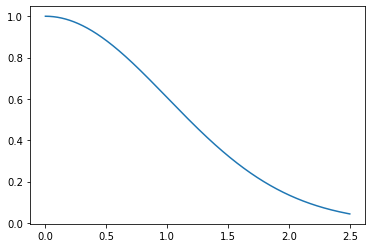

In [20]:
M_FACTOR_TABLE = np.load("M_FACTOR_TABLE.npy")
plt.figure()
y_plot = [M_FACTOR_TABLE[0, 0, ld] for ld in np.arange(LD_LEN)]
plt.plot(LD_GRID, y_plot)